In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
fol = '/home/alessio/m-dynamicshere/results'
subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> 1_2_nac_0000
1 -> 1_2_nac_THETA_0000
2 -> 1_2_nac_THETA_0001



In [3]:
interactive = True
%matplotlib notebook
subfolder = subfolders[-1]
# subfolder = subfolders[21]

In [4]:
a = os.path.join(fol,subfolder)
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
kind = dictio['kind']
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
lastV = len(filesList)-1

In [5]:
kind
if kind != 'The' and kind != 'Phi' and kind != 'Gam':
    qp.err('This is 1D notebook !!!')

# 1d slices

In [6]:
filesN = len(filesList)
dime,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
allwf = np.empty((filesN,dime,nstates),dtype=complex)
alltime = np.empty((filesN))
if kind == 'Phi':
    dim = phis
elif kind == 'Gam':
    dim = gams
elif kind == 'The':
    dim = thes

In [7]:
for i,fn in enumerate(filesList):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]
    

In [8]:
outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']
result = pd.concat([data, dataP], axis=1)

In [9]:
potential = qp.fromHartoEv(dictio['potCube'])
potential.shape,dim.shape, np.arange(nstates)[:-1]

((160, 2), (160,), array([0]))

In [10]:
def plotDim1D(i,magni,save=None):
    wf = allwf[i]
    fig = plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']
    save = save or False
    
  
    all_states_indexes = np.arange(2)
    time = alltime[i]
     
    #plt.title('{} - Time = {:10.5f} fs'.format(kind,time))   <- this is the good one, I used the other one to make video of presentation
    plt.title('Time = {:10.5f} fs'.format(time))
    plt.xticks([])
    plt.yticks([])
    
    
    ax1 = fig.add_subplot(2,2,4)
    #ax1 = fig.add_axes([0.00, 0.5, 0.25, 0.5],xticklabels=[])
    ax1.set_ylim ([-1,11])
    #ax1.set_xticks([])
    potential = qp.fromHartoEv(dictio['potCube'])
    
    for jj in all_states_indexes:
        ax1.plot(dim, potential[:,jj], linewidth=1.5,ls='-', color = colors[jj])
    
    high = [0.5,2,6.4]
    position = [3,1,2]
    
    for state in all_states_indexes:
        ax1 = fig.add_subplot(2,2,position[state])
        ax1.set_ylim([-1,11])
        if state in [2]:
            ax1.set_yticks([])
        if state in [1,2]:
            ax1.set_xticks([])

        magnification_of_Abs_part = 5
        initialEne = result['Total'][0]
        initialEne = initialEne + high[state]
        ys = wf[:,state]
        realPart = np.real(ys)*magni + initialEne
        imagPart = np.imag(ys)*magni + initialEne
        absPart = abs2(ys)*magnification_of_Abs_part*magni + initialEne
        
        
        ax1.plot(dim, realPart, linewidth=1,ls='--')
        ax1.plot(dim, imagPart, linewidth=1,ls='--')
        ax1.plot(dim, absPart, linewidth=2,ls='--', color=colors[state])
        ax1.plot(dim, potential[:,state],linewidth=1,ls='-',color=colors[state])
        
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    #fig.tight_layout()
    
    if save:
        name_fig = '1D_Wavefunction{:04d}.png'.format(i)
        fig.savefig(name_fig, dpi=200)
    
    
def fdim(file_number,magni):
    return plotDim1D(file_number,magni)

#fdim(0,10)

# #visualize NAC along here
# ah = dictio['nacCube'][:,0,1,2]
# fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(thes,ah);

In [11]:
if interactive:
    interact(fdim, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), magni = widgets.IntSlider(min=1,max=20,step=1,value=2));
else:
    magni = 2
    print('initial')
    fdim(0,magni)
    print('final')
    fdim(lastV,magni)
    
savefigures = False
if savefigures:
    plt.ioff()
    for i in range(lastV):
        plotDim1D(i,10,True)
    plt.ion()
        

interactive(children=(IntSlider(value=150, description='file_number', max=150), IntSlider(value=2, description…

<IPython.core.display.Javascript object>


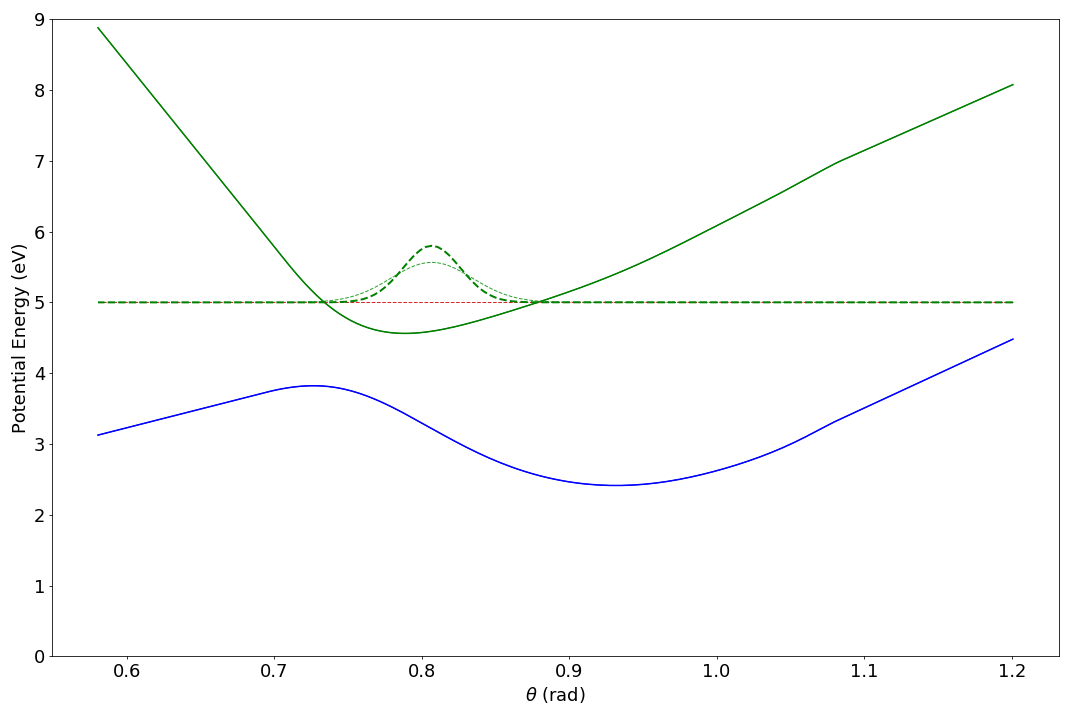

In [33]:
def plotDim1D(i,magni,save=None):
    wf = allwf[i]
    fig = plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']
    save = save or False
    
  
    all_states_indexes = np.arange(2)
    time = alltime[i]
     
    #plt.title('{} - Time = {:10.5f} fs'.format(kind,time))   <- this is the good one, I used the other one to make video of presentation
    #plt.title('Time = {:10.5f} fs'.format(time))
    #plt.xticks([])
    #plt.yticks([])
    plt.ylim([0,9])
    plt.ylabel('Potential Energy (eV)')
    plt.xlabel(r'$\theta$ (rad)')
    #ax1 = fig.add_subplot(2,2,4)
    #ax1 = fig.add_axes([0.00, 0.5, 0.25, 0.5],xticklabels=[])
    #ax1.set_ylim ([-1,11])
    #ax1.set_xticks([])
    potential = qp.fromHartoEv(dictio['potCube'])
    plt.rcParams.update({'font.size': 12})
    
    for jj in all_states_indexes:
        plt.plot(dim, potential[:,jj], linewidth=1.5,ls='-', color = colors[jj])
    
    high = [-2,5,6.4]
    position = [3,1,2]
    
    
    
    for state in all_states_indexes:
#         ax1 = fig.add_subplot(2,2,position[state])
        
#         if state in [2]:
#             ax1.set_yticks([])
#         if state in [1,2]:
#             ax1.set_xticks([])

        magnification_of_Abs_part = 5
        #initialEne = result['Total'][0]
        initialEne = 0
        initialEne = initialEne + high[state]
        ys = wf[:,state]
        realPart = np.real(ys)*magni + initialEne
        imagPart = np.imag(ys)*magni + initialEne
        absPart = abs2(ys)*magnification_of_Abs_part*magni + initialEne

        plt.plot(dim, realPart, linewidth=1,ls='--')
        plt.plot(dim, imagPart, linewidth=1,ls='--')
        plt.plot(dim, absPart, linewidth=2,ls='--', color=colors[state])
        plt.plot(dim, potential[:,state],linewidth=1,ls='-',color=colors[state])
        
#     plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    fig.tight_layout()
    
    if save:
        name_fig = '1D_Wavefunction{:04d}.png'.format(i)
        fig.savefig(name_fig, dpi=300)
    
    
def fdim(file_number,magni):
    return plotDim1D(file_number,magni)


plotDim1D(0,2,save=True)

In [34]:
def kinGam(xder):
    pd.DataFrame(dictio['kinCube'][:,4,xder]).plot(x=dim,figsize=(11, 6))
    
interact(kinGam, xder = widgets.IntSlider(min=0,max=2,step=1,value=0));

interactive(children=(IntSlider(value=0, description='xder', max=2), Output()), _dom_classes=('widget-interact…

In [35]:
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2
0,0,0,0.000000,1.110223e-16,0.000180,4.618753,4.618933,0.000000,0.0,0.0,0.0,0.0000,0.000000,1.000000
1,1,1000,1.000993,-1.270296e-02,0.000042,4.721166,4.721208,-0.102275,0.0,0.0,0.0,1.0010,0.012554,1.013010
2,2,2000,2.001985,-2.072607e-02,-0.000277,4.788098,4.787821,-0.168888,0.0,0.0,0.0,2.0020,0.020250,1.021630
3,3,3000,3.002978,-9.453161e-03,-0.000244,4.696642,4.696399,-0.077466,0.0,0.0,0.0,3.0030,0.008743,1.010250
4,4,4000,4.003971,-5.174568e-03,0.000272,4.659740,4.660012,-0.041079,0.0,0.0,0.0,4.0040,0.004851,1.005530
5,5,5000,5.004964,-1.208891e-02,0.000548,4.715616,4.716164,-0.097231,0.0,0.0,0.0,5.0050,0.011920,1.012400
6,6,6000,6.005956,-1.563566e-02,0.000282,4.746424,4.746707,-0.127774,0.0,0.0,0.0,6.0060,0.014951,1.016560
7,7,7000,7.006949,-1.204264e-02,0.000083,4.717436,4.717518,-0.098586,0.0,0.0,0.0,7.0069,0.010808,1.013420
8,8,8000,8.007942,-8.657028e-03,0.000506,4.688389,4.688895,-0.069962,0.0,0.0,0.0,8.0079,0.007592,1.009800
9,9,9000,9.008935,-1.019507e-02,0.001134,4.700061,4.701195,-0.082263,0.0,0.0,0.0,9.0089,0.009553,1.010940


<IPython.core.display.Javascript object>


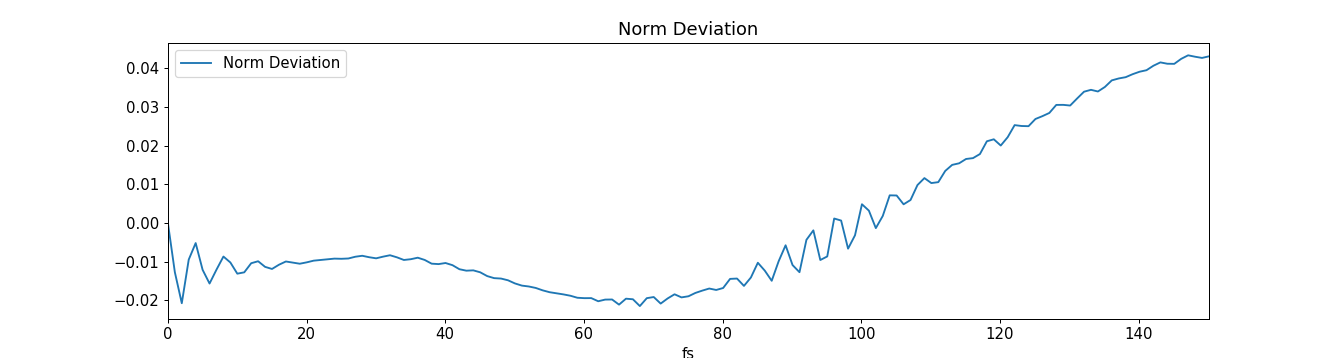

<IPython.core.display.Javascript object>


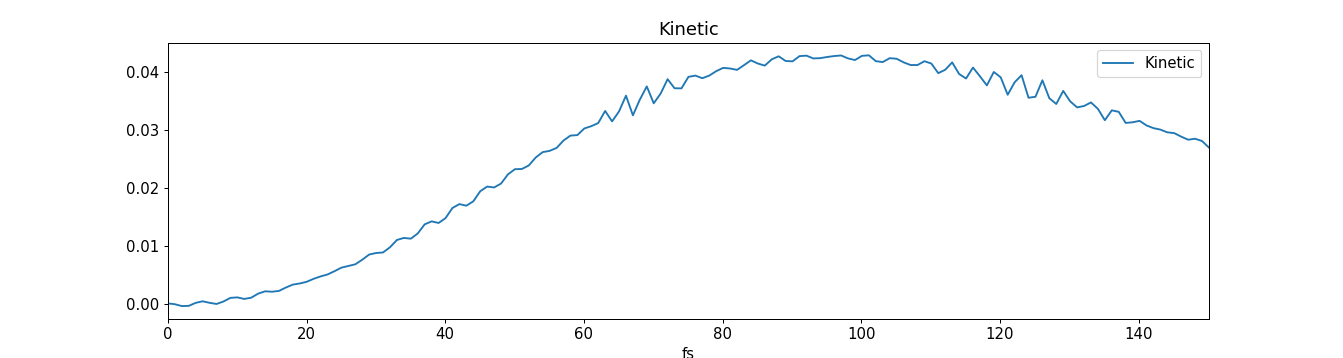

<IPython.core.display.Javascript object>


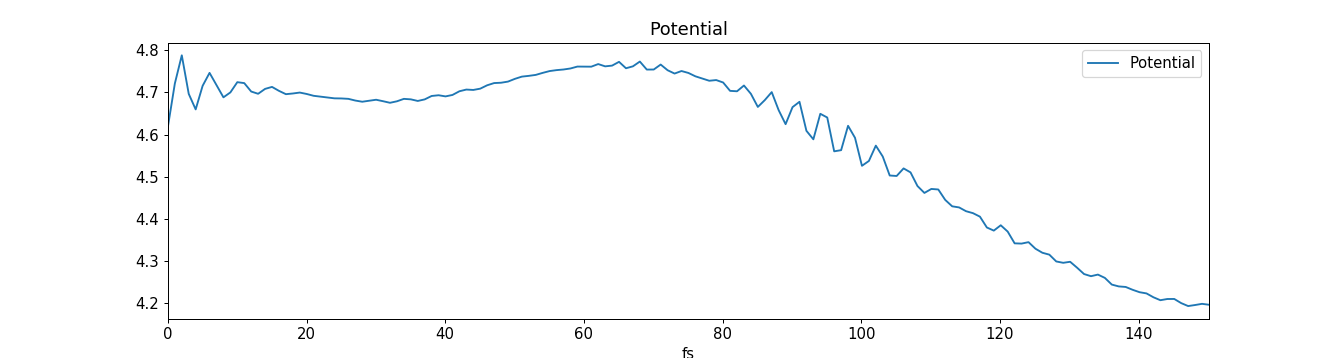

<IPython.core.display.Javascript object>


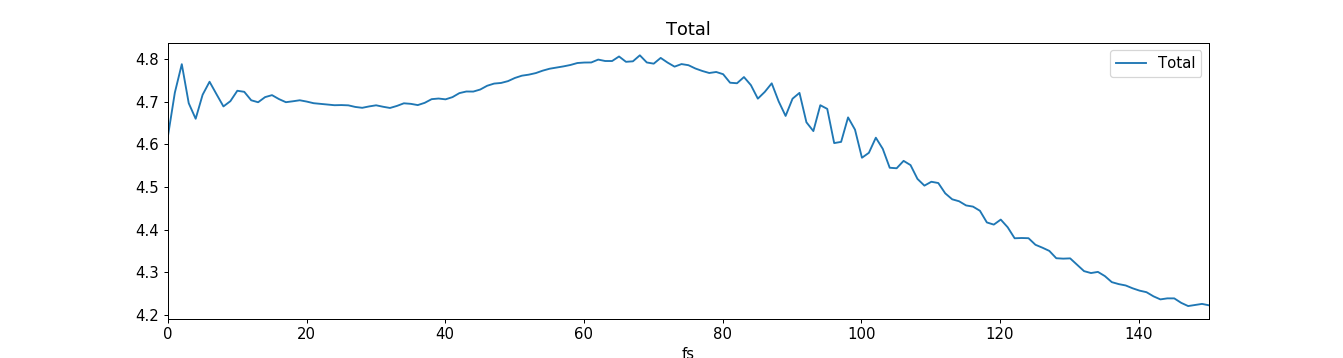

In [36]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

<IPython.core.display.Javascript object>


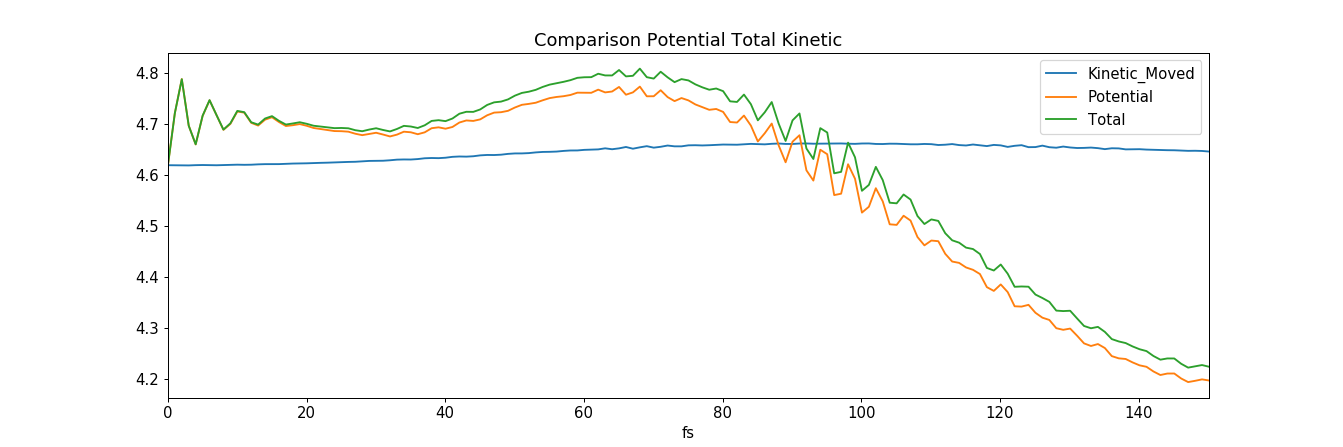

In [37]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

<IPython.core.display.Javascript object>


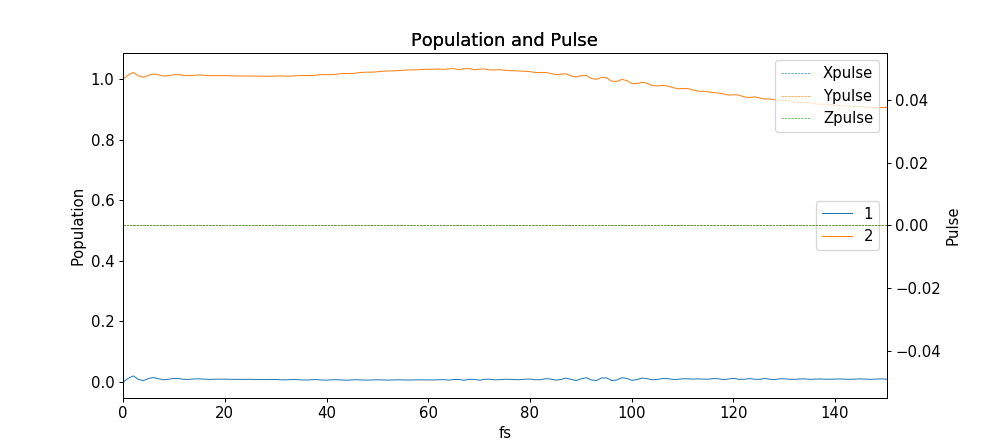

In [38]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5, ls='--');

In [39]:
# fig = plt.figure(figsize=(13,8))

# ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6],xticklabels=[])
# ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])

# ax1.set_ylabel('Population')

# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']

# x1 = result['fs'][:200]
# for i in np.arange(3):
#     y1 = result[i+1][:200]
#     col = colors[i]
#     laby = r'$S_{{{}}}$'.format(i)
#     ax1.plot(x1,y1,color=col, label=laby)

# ax2.set_ylabel('Pulse (eV)')

# y2 = result['Xpulse'][:200]
# ax2.set_xlabel('fs')
# ax2.plot(x1,y2)
# ax1.legend()

# plt.savefig('vediamo.svg')


## Expected Value

In [40]:
def expected_1d(i):
    wf = allwf[i]
    time = alltime[i]
    print('  Time: {:5.2f} fs'.format(time))
    _,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('  Expected Values State {}:\n  Popul: {:10.3f} \n    {}: - \n'.format(i, popu**2,kind))
        else:
            wfA = abs2(wfState/popu)
            dimA = sum([ wfA[i] * dim[i] for i in range(wfA.size) ])
            print('  Expected Values State {}:\n  Popul: {:10.3f} \n    {}:   {:10.3f} \n'.format(i, popu**2, kind, dimA))

if interactive:
    interact(expected_1d, i = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    expected_1d(0)
    print('Last Step:')
    expected_1d(lastV)

interactive(children=(IntSlider(value=150, description='i', max=150), Output()), _dom_classes=('widget-interac…

## Borders amplitudes

In [41]:
def border(i):
    left  = abs2(allwf[i,0])
    right = abs2(allwf[i,-1])
    print('Border Population:\nLeft  {}\nRight {}'.format(left,right))
    
if interactive:
    interact(border, i = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    border(0)
    print('Last Step:')
    border(lastV)

interactive(children=(IntSlider(value=150, description='i', max=150), Output()), _dom_classes=('widget-interac…

In [42]:
# %%bash -s "$kind"
# jupyter nbconvert --to html Heatmaps1d.ipynb
# mv Heatmaps1d.html ~/Desktop/$(date +"%m_%d_%Y-%H%M%S")_${1}_Heatmaps1d.html

In [43]:
nnnn = dictio['nacCube'][30:-30]

In [44]:
print(nnnn.shape)
a = nnnn[:,0,1,2]

(100, 2, 2, 3)


In [45]:
the_cut = thes[30:-30]

<IPython.core.display.Javascript object>


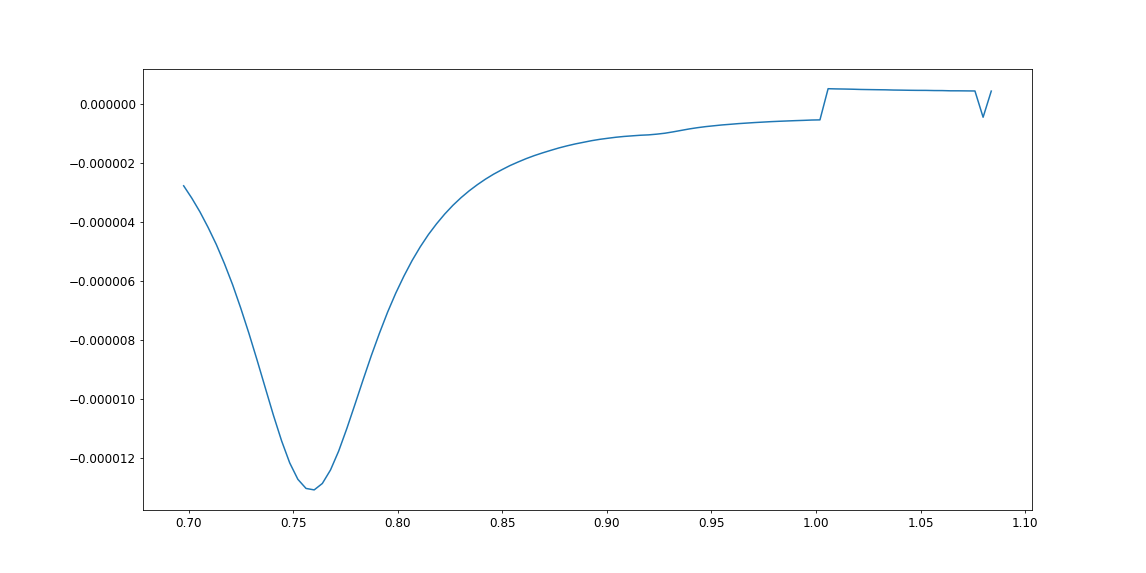

In [46]:
fig = plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(the_cut,a);

In [55]:
name = 'what_NAC_1_0.txt'
np.savetxt(name,a)

In [56]:
nameThis = 'what_PES_0.txt'
np.savetxt(nameThis,potential[:,0])

In [57]:
nameThat = 'what_PES_1.txt'
np.savetxt(nameThat,potential[:,1])

In [58]:
nameGrids = 'what_position.txt'
np.savetxt(nameGrids,thes)